In [1]:
# Cell 1: Install Required Libraries
!pip install -q pandas scikit-learn matplotlib torch sentence-transformers pydrive
!pip install -q torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.8 MB/s eta 0:00:00


In [2]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import re
import math
from scipy.stats import spearmanr
import torch
from sentence_transformers import SentenceTransformer, CrossEncoder
from google.colab import auth, drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from huggingface_hub import login

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Cell 3: Mount Google Drive (Optional, if dataset is in Drive)

# Cell 4: Define Utility Functions
def simple_clean(text):
    """Clean text by converting to lowercase and normalizing spaces."""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [4]:
# Cell 5: Load Data (Using Set 1's CSV dataset)
try:
    df = pd.read_excel('/content/synthetic_resume_summaries (1).xlsx')  # Adjust path if needed
    all_texts = df["text"].tolist()
    all_summaries = df["summary"].tolist()
    print(f"Number of samples: {len(all_texts)}")
except FileNotFoundError:
    print("Error: Dataset file not found. Please upload 'synthetic_resume_summaries (1).xlsx'.")
    raise

Number of samples: 1000


In [5]:
# Cell 6: Split Data into Train and Test
num_samples = len(all_texts)
test_size = min(100, num_samples)  # Use up to 100 samples for testing
if num_samples > test_size:
    train_indices, test_indices = train_test_split(range(num_samples), test_size=test_size, random_state=42)
else:
    test_indices = list(range(num_samples))
    print(f"Warning: Number of samples {num_samples} <= test_size {test_size}, using all as test.")
print(f"Train indices: {len(train_indices)}")
print(f"Test indices: {len(test_indices)}")

Train indices: 900
Test indices: 100


In [6]:
# Cell 7: Prepare Corpus and Queries
corpus = all_texts  # Full documents
queries = [all_summaries[i] for i in test_indices]  # Summaries as queries
print(f"Corpus size: {len(corpus)}")
print(f"Query size: {len(queries)}")

Corpus size: 1000
Query size: 100


In [7]:
# Cell 9: Load Embedding Model (From Set 2)
model_name = "all-MiniLM-L6-v2"#"Lajavaness/bilingual-embedding-large"
print(f"Loading embedding model: {model_name}")
model = SentenceTransformer(model_name, trust_remote_code=True)
if torch.cuda.is_available():
    model = model.cuda()
print(f"Model loaded on {'GPU' if torch.cuda.is_available() else 'CPU'}")

Loading embedding model: all-MiniLM-L6-v2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded on GPU


In [8]:
# Cell 10: Encode Corpus and Queries
print("Encoding corpus and queries...")
corpus_embeddings = model.encode([simple_clean(doc) for doc in corpus], batch_size=64, normalize_embeddings=True)
query_embeddings = model.encode([simple_clean(q) for q in queries], batch_size=64, normalize_embeddings=True)

Encoding corpus and queries...


In [9]:
# Convert to numpy for cosine similarity
corpus_embeddings_np = np.array(corpus_embeddings)
query_embeddings_np = np.array(query_embeddings)
print(f"Corpus embeddings shape: {corpus_embeddings_np.shape}")
print(f"Query embeddings shape: {query_embeddings_np.shape}")

Corpus embeddings shape: (1000, 384)
Query embeddings shape: (100, 384)


In [10]:
# Cell 11: Initial Ranking (Cosine Similarity)
print("Performing initial ranking with cosine similarity...")
similarities = cosine_similarity(query_embeddings_np, corpus_embeddings_np)
print(f"Similarities matrix shape: {similarities.shape}")

Performing initial ranking with cosine similarity...
Similarities matrix shape: (100, 1000)


In [11]:
# Create ranked results dictionary
ranked_results = {}
for k in range(len(queries)):
    qid = f"q{k}"
    ranked_indices = np.argsort(similarities[k, :])[::-1]
    ranked_docs = [corpus[i] for i in ranked_indices]
    ranked_scores = [similarities[k, i] for i in ranked_indices]
    ranked_results[qid] = {
        'ranked_docs': ranked_docs,
        'ranked_scores': ranked_scores
    }
print("Initial ranking completed.")

Initial ranking completed.


In [12]:
# Cell 12: Load Reranker Model (From Set 2)
print("Loading reranker model...")
reranker_model = CrossEncoder('cross-encoder/stsb-roberta-large')
if torch.cuda.is_available():
    reranker_model.model = reranker_model.model.cuda()
print("Reranker model loaded.")

Loading reranker model...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

Reranker model loaded.


In [13]:
# Cell 13: Rerank Top-K Documents
top_k = 10
print(f"Reranking top {top_k} documents...")
reranked_results = {}
for k in range(len(queries)):
    qid = f"q{k}"
    query = queries[k]
    top_docs = ranked_results[qid]['ranked_docs'][:top_k]
    pairs = [[query, doc] for doc in top_docs]
    scores = reranker_model.predict(pairs)
    reranked = sorted(zip(top_docs, scores), key=lambda x: x[1], reverse=True)
    reranked_results[qid] = {
        'ranked_docs': [doc for doc, _ in reranked],
        'ranked_scores': [score for _, score in reranked]
    }
print("Reranking completed.")

Reranking top 10 documents...
Reranking completed.


In [14]:
# Cell 14: Evaluate Metrics (For both Initial and Reranked Results)
def evaluate_results(ranked_results, queries, test_indices, corpus):
    """Evaluate ranking performance with MRR, MAP, NDCG, Accuracy, and Spearman."""
    print("\nEvaluating performance...")
    AP_total = 0.0
    MRR_total = 0.0
    nDCG_total = 0.0
    spearman_total = 0.0
    top1_correct = 0
    valid_query_count = len(queries)

    for k in range(len(queries)):
        qid = f"q{k}"
        ranked_docs = ranked_results[qid]['ranked_docs']
        scores = ranked_results[qid]['ranked_scores']
        true_doc = corpus[test_indices[k]]  # Ground truth document

        # Create labels (1 for relevant, 0 for irrelevant)
        labels = [1 if doc == true_doc else 0 for doc in ranked_docs]

        # MAP
        ap = 0.0
        rel_count = 0
        for rank, label in enumerate(labels, start=1):
            if label == 1:
                rel_count += 1
                precision_at_rank = rel_count / rank
                ap += precision_at_rank
        if rel_count > 0:
            ap /= rel_count
        AP_total += ap

        # MRR
        rr = 0.0
        for rank, label in enumerate(labels, start=1):
            if label == 1:
                rr = 1.0 / rank
                break
        MRR_total += rr

        # Top-1 Accuracy
        if labels[0] == 1:
            top1_correct += 1

        # NDCG
        dcg = 0.0
        for rank, label in enumerate(labels, start=1):
            if label == 1:
                dcg += 1.0 / math.log2(rank + 1)
        idcg = 1.0 / math.log2(2)  # Ideal DCG (relevant doc at rank 1)
        nDCG_total += (dcg / idcg) if idcg > 0 else 0.0

        # Spearman
        if len(scores) > 1 and 0 < sum(labels) < len(scores):
            rho, _ = spearmanr(scores, labels)
            spearman = rho if not math.isnan(rho) else 0.0
        else:
            spearman = 1.0 if sum(labels) == len(labels) or sum(labels) == 1 else 0.0
        spearman_total += spearman

    metrics = {
        'MAP': AP_total / valid_query_count,
        'MRR': MRR_total / valid_query_count,
        'Accuracy': top1_correct / valid_query_count,
        'nDCG': nDCG_total / valid_query_count,
        'Spearman': spearman_total / valid_query_count
    }
    return metrics

In [15]:
# Evaluate Initial Ranking
print("\nInitial Ranking Metrics:")
initial_metrics = evaluate_results(ranked_results, queries, test_indices, corpus)
for metric, value in initial_metrics.items():
    print(f"- {metric}: {value:.4f}")


Initial Ranking Metrics:

Evaluating performance...
- MAP: 0.8089
- MRR: 0.8089
- Accuracy: 0.7500
- nDCG: 0.8487
- Spearman: 0.0542


In [16]:
# Evaluate Reranked Results
print("\nReranked Metrics:")
reranked_metrics = evaluate_results(reranked_results, queries, test_indices, corpus)
for metric, value in reranked_metrics.items():
    print(f"- {metric}: {value:.4f}")


Reranked Metrics:

Evaluating performance...
- MAP: 0.8289
- MRR: 0.8289
- Accuracy: 0.7900
- nDCG: 0.8462
- Spearman: 0.4340


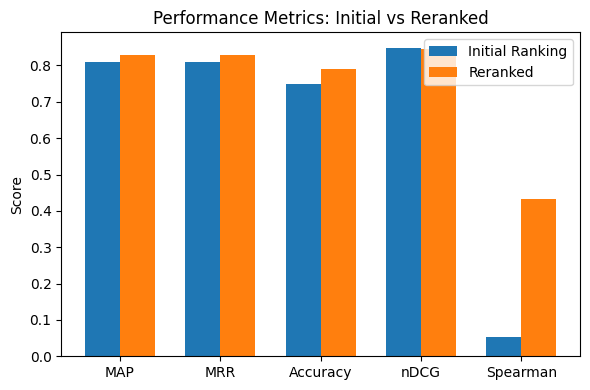

In [17]:
# Cell 15: Visualize Metric Comparison
metrics_names = list(initial_metrics.keys())
initial_values = [initial_metrics[m] for m in metrics_names]
reranked_values = [reranked_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x - width/2, initial_values, width, label='Initial Ranking', color='#1f77b4')
ax.bar(x + width/2, reranked_values, width, label='Reranked', color='#ff7f0e')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics: Initial vs Reranked')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
plt.tight_layout()
plt.show()